# Chapter 07: Neural Networks

In [83]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

## Concepts

### Activation Functions

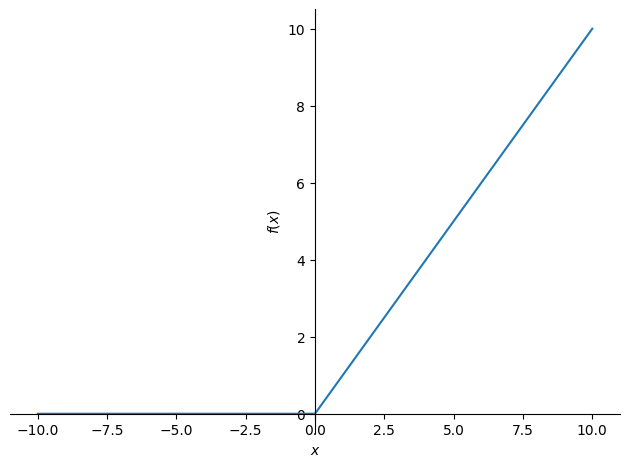

In [2]:
# Plot ReLU (Rectified Linear Unit)

x = sympy.symbols('x')
relu = sympy.Max(0, x)
sympy.plot(relu)

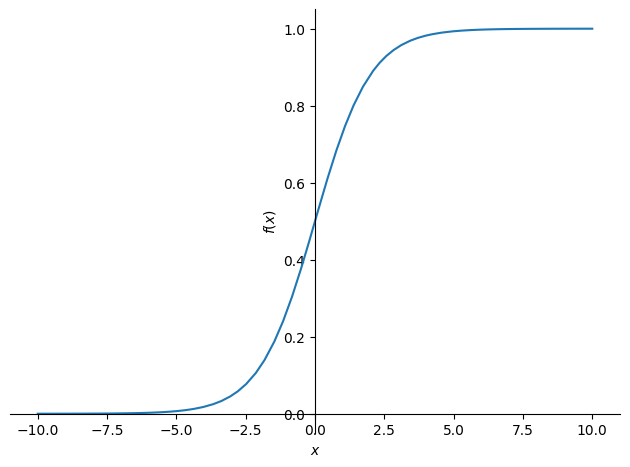

In [3]:
# Plot logistic

x = sympy.symbols('x')
logistic = 1 / (1 + sympy.exp(-x))
sympy.plot(logistic)

### Forward Propagation

In [4]:
# A simple feed forward network with random weights and bias

# Load and prep data
df = pd.read_csv("https://tinyurl.com/y2qmhfsr")

X = (df.iloc[:, 0:3].values / 255)
Y = df.iloc[:, -1].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3)
num_examples = X_train.shape[0]

# Initialize network matrices
w_hidden = np.random.rand(3, 3)
w_output = np.random.rand(1, 3)

b_hidden = np.random.rand(3, 1)
b_output = np.random.rand(1, 1)

# Activation functions
relu = lambda x: np.maximum(x, 0)
logistic = lambda x: 1 / (1 + np.exp(-x))


def forward_prop(X):
    Z1 = w_hidden @ X + b_hidden
    A1 = relu(Z1)
    Z2 = w_output @ X + b_output
    A2 = logistic(Z2)
    return Z1, A1, Z2, A2

# Calculate accuracy
test_predictions = forward_prop(X_test.transpose())[3]
test_comparisons = np.equal((test_predictions >= 0.5).flatten().astype(int), Y_test)
accuracy = sum(test_comparisons.astype(int) / X_test.shape[0])
print("Accuracy:", accuracy)

Accuracy: 0.6280623608017807


### BackPropagation

In [5]:
# Finding the derivative of A2 with respect to Z2

logistic = lambda x: 1 / (1 + sympy.exp(-x))

Z2 = sympy.symbols("Z2")
A2 = logistic(Z2)

dA2_dZ2 = sympy.diff(A2, Z2)
print(dA2_dZ2)

exp(-Z2)/(1 + exp(-Z2))**2


In [6]:
# Finding the derivative of Z2 with respect to W2

A1, W2, B2 = sympy.symbols("A1 W2 B2")
Z2 = (W2 * A1) + B2

dZ2_dW2 = sympy.diff(Z2, W2)
print(dZ2_dW2)

A1


In [7]:
# Calculating all the partial derivatives we will need for our neural network
# These can be chained together using the chain rule to calculate each parameters derivative with respect to the Loss Function\

W1, W2, B1, B2, A1, A2, Z1, Z2, X, Y = sympy.symbols("W1 W2 B1 B2 A1 A2 Z1 Z2 X Y")

# Derivative of Loss function with respect to A2
C = (A2 - Y)**2
dC_dA2 = sympy.diff(C, A2)
print("dC_dA2 = ", dC_dA2)

# Derivative of A2 with respect to Z2
logistic = lambda x: 1 / (1 + sympy.exp(-x))
_A2 = logistic(Z2)
dA2_dZ2 = sympy.diff(_A2, Z2)
print("dA2_dZ2 = ", dA2_dZ2)

# Derivative of Z2 with respect to W2
_Z2 = (W2*A1) + B2
dZ2_dW2 = sympy.diff(_Z2, W2)
print("dZ2_dW2 = ", dZ2_dW2)

# Derivative of Z2 with respect to B2
dZ2_dB2 = sympy.diff(_Z2, B2)
print("dZ2_dB2 = ", dZ2_dB2)

# Derivative of A1 with respect to Z1
relu = lambda x: sympy.Max(x, 0)
_A1 = relu(Z1)
d_relu = lambda x: x > 0
dA1_dZ1 = d_relu(Z1)
print("dA1_dZ1 = ", dA1_dZ1)

# Derivative of Z1 with respect to W1
_Z1 = (W1*X) + B1
dZ1_dW1 = sympy.diff(_Z1, W1)
print("dA1_dZ1 = ", dZ1_dW1)

# Derivative of Z1 with respect to B1
dZ1_dB1 = sympy.diff(_Z1, B1)
print("dZ1_dB1 = ", dZ1_dB1)

dC_dA2 =  2*A2 - 2*Y
dA2_dZ2 =  exp(-Z2)/(1 + exp(-Z2))**2
dZ2_dW2 =  A1
dZ2_dB2 =  1
dA1_dZ1 =  Z1 > 0
dA1_dZ1 =  X
dZ1_dB1 =  1


In [8]:
# Stochastic Gradient Descent

# Load and prep data
df = pd.read_csv("https://tinyurl.com/y2qmhfsr")

X = (df.iloc[:, 0:3].values / 255)
Y = df.iloc[:, -1].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3)
num_examples = X_train.shape[0]

# Initialize network matrices
w_hidden = np.random.rand(3, 3)
w_output = np.random.rand(1, 3)

b_hidden = np.random.rand(3, 1)
b_output = np.random.rand(1, 1)

# Activation functions
relu = lambda x: np.maximum(x, 0)
logistic = lambda x: 1 / (1 + np.exp(-x))

def forward_prop(X):
    Z1 = w_hidden @ X + b_hidden
    A1 = relu(Z1)
    Z2 = w_output @ A1 + b_output
    A2 = logistic(Z2)
    return Z1, A1, Z2, A2

# Derivatives of activation functions
d_relu = lambda x: x > 0
d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

def backprop(Z1, A1, Z2, A2, X, Y):
    dC_dA2 = 2 * A2 - 2 * Y
    dA2_dZ2 = d_logistic(Z2)
    dZ2_dA1 = w_output
    dZ2_dW2 = A1
    dZ2_dB2 = 1
    dA1_dZ1 = d_relu(Z1)
    dZ1_dW1 = X
    dZ1_dB1 = 1

    dC_dW2 = dC_dA2 @ dA2_dZ2 @ dZ2_dW2.T
    dC_dB2 = dC_dA2 @ dA2_dZ2 * dZ2_dB2
    dC_dA1 = dC_dA2 @ dA2_dZ2 @ dZ2_dA1
    dC_dW1 = dC_dA1 @ dA1_dZ1 @ dZ1_dW1.T
    dC_dB1 = dC_dA1 @ dA1_dZ1 * dZ1_dB1

    return dC_dW1, dC_dB1, dC_dW2, dC_dB2

# Training loop
learning_rate = 0.05
for i in range(100_000):
    # randomly select one of the training data
    idx = np.random.choice(num_examples, 1, replace=False)
    X_sample = X_train[idx].transpose()
    Y_sample = Y_train[idx]

    # run randomly selected training data through neural network
    Z1, A1, Z2, A2 = forward_prop(X_sample)

    # distribute error through backpropagation
    # and return slopes for weights and biases
    dW1, dB1, dW2, dB2 = backprop(Z1, A1, Z2, A2, X_sample, Y_sample)

    # update weights and biases
    w_hidden -= learning_rate * dW1
    b_hidden -= learning_rate * dB1
    w_output -= learning_rate * dW2
    b_output -= learning_rate * dB2

# Calculate accuracy
test_predictions = forward_prop(X_test.transpose())[3]
test_comparisons = np.equal((test_predictions >= .5).flatten().astype(int), Y_test)
accuracy = sum(test_comparisons.astype(int) / X_test.shape[0])
print("ACCURACY: ", accuracy)

ACCURACY:  0.9933184855233778


In [14]:
# Adding an interactive shell to our neural network

def predict_probability(r, g, b):
    X = np.array([[r, g, b]]).transpose() / 255
    Z1, A1, Z2, A2 = forward_prop(X)
    return A2

def predict_font_shade(r, g, b):
    output_values = predict_probability(r, g, b)
    if output_values > .5:
        return "DARK"
    else:
        return "LIGHT"


r1, g1, b1 = [255, 255, 255]
prediction_1 = predict_font_shade(r1, g1, b1)
print(f"Prediction: Background for RGB color [{r1}, {g1}, {b1}] should be {prediction_1}.")

r2, g2, b2 = [0, 0, 0]
prediction_2 = predict_font_shade(r2, g2, b2)
print(f"Prediction: Background for RGB color [{r2}, {g2}, {b2}] should be {prediction_2}.")

Prediction: Background for RGB color [255, 255, 255] should be DARK.
Prediction: Background for RGB color [0, 0, 0] should be LIGHT.


### Neural Network 3Using Scikit-Learn

In [18]:
# Using scikit-learn neural network classifier

df = pd.read_csv("https://bit.ly/3GsNzGt", delimiter=",")

X = (df.iloc[:, :-1].values / 255)
Y = df.iloc[:, -1].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3)

nn = MLPClassifier(
    solver='sgd',
    hidden_layer_sizes=(3,),
    activation='relu',
    max_iter=100_000,
    learning_rate_init=0.05
)

nn.fit(X_train, Y_train)
print("Coefficients:", nn.coefs_)
print("Intercepts:", nn.intercepts_)
print("\n")
print("Training set score: %f" % nn.score(X_train, Y_train))
print("Test set score: %f" % nn.score(X_test, Y_test))

Coefficients: [array([[ 0.32468387, -0.47062262,  3.55799164],
       [-1.91432682, -1.14114718,  6.64423881],
       [-0.58786831, -1.096965  ,  1.09190803]]), array([[-2.98406903],
       [ 0.69521107],
       [ 8.81331503]])]
Intercepts: [array([ 2.62778878,  0.03226775, -4.74105556]), array([-3.4335337])]


Training set score: 0.995536
Test set score: 0.991091


## Code Exercises

Epoch [1000/10000], Train Loss: 0.6881, Test Loss: 0.6840
Epoch [2000/10000], Train Loss: 0.6600, Test Loss: 0.6890
Epoch [3000/10000], Train Loss: 0.6193, Test Loss: 0.6625
Epoch [4000/10000], Train Loss: 0.5698, Test Loss: 0.6728
Epoch [5000/10000], Train Loss: 0.5311, Test Loss: 0.6484
Epoch [6000/10000], Train Loss: 0.5122, Test Loss: 0.6271
Epoch [7000/10000], Train Loss: 0.5022, Test Loss: 0.6189
Epoch [8000/10000], Train Loss: 0.4942, Test Loss: 0.6226
Epoch [9000/10000], Train Loss: 0.4868, Test Loss: 0.6227
Epoch [10000/10000], Train Loss: 0.4823, Test Loss: 0.6209


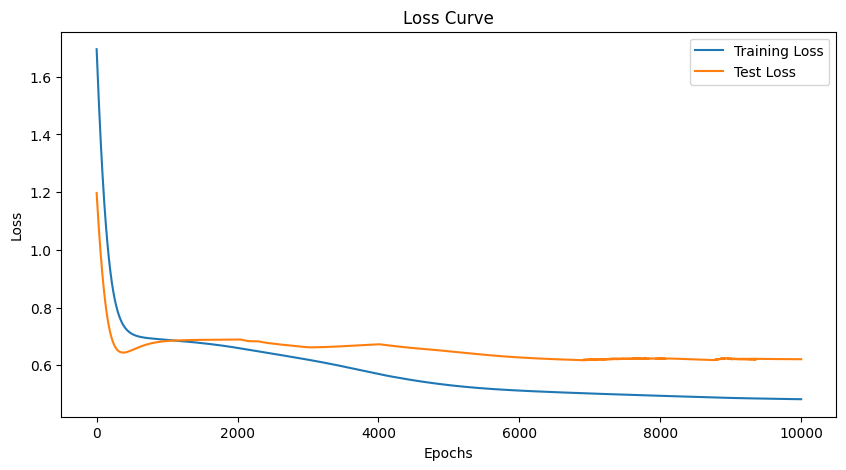

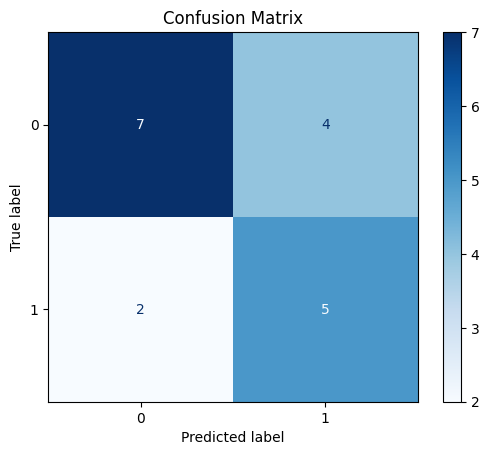

Training Accuracy: 0.7778
Test Accuracy: 0.6667


In [89]:
# Exercise 7-1 Train & Evaluate a neural network on Employee retention data

# Load the dataset
df = pd.read_csv("https://tinyurl.com/y6r7qjrp", delimiter=",")
X = (df.iloc[:, :-1].values)
Y = df.iloc[:, -1].values

# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)  # Make Y a column vector
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)  # Make Y a column vector

# Define the neural network architecture
class SimpleNN(torch.nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(X_train.shape[1], 3)  # Input layer to hidden layer
        self.fc2 = torch.nn.Linear(3, 1)  # Hidden layer to output layer
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

# Track losses for plotting
train_losses = []
test_losses = []

# Train the model
num_epochs = 10_000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    train_loss = criterion(output, Y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_output = model(X_test_tensor)
        test_loss = criterion(test_output, Y_test_tensor)

    # Store losses for plotting
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Evaluate the final model accuracy
model.eval()
with torch.no_grad():
    train_predictions = (model(X_train_tensor) > 0.5).float()
    test_predictions = (model(X_test_tensor) > 0.5).float()

    train_accuracy = (train_predictions.eq(Y_train_tensor)).sum() / float(Y_train_tensor.shape[0])
    test_accuracy = (test_predictions.eq(Y_test_tensor)).sum() / float(Y_test_tensor.shape[0])

# Confusion Matrix
test_predictions_np = test_predictions.numpy()
Y_test_np = Y_test_tensor.numpy()

cm = confusion_matrix(Y_test_np, test_predictions_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

In [90]:
print("Our model is slightly overfit, given an NN is overkill for this task. Although, this illustrates how to build a simple classifier Neural Network in Pytorch!")

Our model is slightly overfit, given an NN is overkill for this task. Although, this illustrates how to build a simple classifier Neural Network in Pytorch!
